<a href="https://colab.research.google.com/github/yigitv4rli/CENG501-Spring2022/blob/main/Project_Kose_Varli/experiments/w8a_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries here
import torch 
import math
import json
import pandas as pd
import random
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision 
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from google.colab import drive

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
seed_alg = random.randint(0,100)
torch.manual_seed(seed_alg)
drive.mount('/content/gdrive')

! wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a
! wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a.t
! wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/ijcnn1.tr.bz2
! wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/ijcnn1.t.bz2
! wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/ijcnn1.val.bz2
! bunzip2 ijcnn1.tr.bz2
! bunzip2 ijcnn1.t.bz2
! bunzip2 ijcnn1.val.bz2

Mounted at /content/gdrive
--2022-07-06 21:54:18--  https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3478238 (3.3M)
Saving to: ‘w8a’

w8a                 100%[===================>]   3.32M  7.95MB/s    in 0.4s    

2022-07-06 21:54:19 (7.95 MB/s) - ‘w8a’ saved [3478238/3478238]

--2022-07-06 21:54:19--  https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a.t
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1045870 (1021K) [text/troff]
Saving to: ‘w8a.t’

w8a.t               100%[===================>]   1021K  3.17MB/s    in 0.3s    

2022-07-06 21:54:20 (3.17 MB/s) - ‘w8a.t’ saved [104

# Utility Functions

This section includes utility functions for overall model
1. Learning Schedulers
2. Data Loaders
3. Train and Test Accuracy
4. Result Saving
5. Plotting

In [ ]:
# scheduler functions
def constant_learning_rate_scheduler(lr):
    def scheduler(_):
        return lr
    return scheduler

def cosine_learning_rate_scheduler(lr, epoch_count):
    def scheduler(current_epoch):
        return lr * (1 + math.cos(current_epoch * math.pi / epoch_count))
    return scheduler

def diminishing_learning_rate_scheduler(lr, alpha):
    def scheduler(current_epoch):
        return lr / ((current_epoch + alpha) ** (1/3))
    return scheduler

def exponential_learning_rate_scheduler(lr, alpha):
    def scheduler(current_epoch):
        return lr * (alpha ** current_epoch)
    return scheduler

def save_history_json(file_name, history):
  with open(file_name, "w") as out:
    json.dump(history, out)

In [ ]:
# data loaders for cifar10 and fashionmnist
def create_w8a_row(line):
    row = [0] * 300

    for non_zero in line[1:]:
        loc, value = non_zero.split(":")
        loc, value = int(loc), float(value)
        row[loc-1] = value
    return row


def w8a_data_create():
    w8a_x_train, w8a_y_train = list(), list()
    with open("w8a", "r") as f:
        lines = f.readlines()

        for line in lines:
            line = line.strip().split()
            w8a_y_train.append(float(line[0]))
            row = create_w8a_row(line)
            w8a_x_train.append(row)

    w8a_x_test, w8a_y_test = list(), list()
    with open("w8a.t", "r") as f:
        lines = f.readlines()

        for line in lines:
            line = line.strip().split()
            w8a_y_test.append(float(line[0]))
            row = create_w8a_row(line)
            w8a_x_test.append(row)

    return w8a_x_train, w8a_y_train, w8a_x_test, w8a_y_test

def w8a_data_loader(X_train, Y_train, X_test, Y_test, batch_size, ssmg):
    transform = transforms.Compose([transforms.ToTensor()])
    
    train_set = torch.utils.data.TensorDataset(X_train, Y_train)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

    # a check if the loader is called for Single Shuffling Momentum Gradient (SSMG)
    # we do shuffling once at the beginning then we create the train loader
    if ssmg:
        shuffled_set = torch.utils.data.Subset(train_set, torch.randperm(len(train_set)))
        train_loader = torch.utils.data.DataLoader(shuffled_set, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

    test_set = torch.utils.data.TensorDataset(X_test, Y_test)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

w8a_x_train, w8a_y_train, w8a_x_test, w8a_y_test = w8a_data_create()
w8a_X_train, w8a_Y_train = torch.Tensor(w8a_x_train), torch.Tensor(w8a_y_train)
w8a_X_test, w8a_Y_test = torch.Tensor(w8a_x_test), torch.Tensor(w8a_y_test)
w8a_X_train = torch.reshape(w8a_X_train, (w8a_X_train.shape[0], w8a_X_train.shape[1], 1))
w8a_Y_train = torch.reshape(w8a_Y_train, (w8a_Y_train.shape[0], 1))

w8a_X_test = torch.reshape(w8a_X_test, (w8a_X_test.shape[0], w8a_X_test.shape[1], 1))
w8a_Y_test = torch.reshape(w8a_Y_test, (w8a_Y_test.shape[0], 1))

# loaders for w8a
w8a_train_loader, w8a_test_loader = w8a_data_loader(w8a_X_train, w8a_Y_train, w8a_X_test, w8a_Y_test, 128, False)

In [ ]:
def create_ijcnn1_row(line):
    row = [0] * 22
    
    for non_zero in line[1:]:
        loc, value = non_zero.split(":")
        loc, value = int(loc), float(value)
        row[loc-1] = value
    return row

def ijcnn1_data_create():
    ijcnn1_x_train, ijcnn1_y_train = list(), list()
    with open("ijcnn1.tr", "r") as f:
        lines = f.readlines()

        for line in lines:
            line = line.strip().split()
            row = create_ijcnn1_row(line)
            ijcnn1_x_train.append(row)
            ijcnn1_y_train.append(float(line[0]))
    
    with open("ijcnn1.val", "r") as f:
        lines = f.readlines()

        for line in lines:
            line = line.strip().split()
            row = create_ijcnn1_row(line)
            ijcnn1_x_train.append(row)
            ijcnn1_y_train.append(float(line[0]))

    ijcnn1_x_test, ijcnn1_y_test = list(), list()
    with open("ijcnn1.t", "r") as f:
        lines = f.readlines()

        for line in lines:
            line = line.strip().split()
            row = create_ijcnn1_row(line)
            ijcnn1_x_test.append(row)
            ijcnn1_y_test.append(float(line[0]))
    
    return ijcnn1_x_train, ijcnn1_y_train, ijcnn1_x_test, ijcnn1_y_test

def ijcnn1_data_loader(X_train, Y_train, X_test, Y_test, batch_size, ssmg):
    transform = transforms.Compose([transforms.ToTensor()])
    
    train_set = torch.utils.data.TensorDataset(X_train, Y_train)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

    # a check if the loader is called for Single Shuffling Momentum Gradient (SSMG)
    # we do shuffling once at the beginning then we create the train loader
    if ssmg:
        shuffled_set = torch.utils.data.Subset(train_set, torch.randperm(len(train_set)))
        train_loader = torch.utils.data.DataLoader(shuffled_set, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

    test_set = torch.utils.data.TensorDataset(X_test, Y_test)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader
 
ijcnn1_x_train, ijcnn1_y_train, ijcnn1_x_test, ijcnn1_y_test = ijcnn1_data_create()
ijcnn1_X_train, ijcnn1_Y_train = torch.Tensor(ijcnn1_x_train), torch.Tensor(ijcnn1_y_train)
ijcnn1_X_test, ijcnn1_Y_test = torch.Tensor(ijcnn1_x_test), torch.Tensor(ijcnn1_y_test)

# loaders for ijcnn1
ijcnn1_train_loader, ijcnn1_test_loader = ijcnn1_data_loader(ijcnn1_X_train, ijcnn1_Y_train, ijcnn1_X_test, ijcnn1_Y_test, 128, False)

In [ ]:
def train_and_test_accuracy(model, train_loader, test_loader):
    total, correct = 0, 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device) # 128-1 -1 veya 1
            predicted = torch.zeros(labels.shape)
            outputs = model(images) #128 - 1 scores
            for i, b in enumerate(outputs):
              if b < 0:
                predicted[i] = -1
              else:
                predicted[i] = 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total

    total, correct = 0, 0
    with torch.no_grad():
        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            predicted = torch.zeros(labels.shape)
            outputs = model(images)
            for i, b in enumerate(outputs):
              if b < 0:
                predicted[i] = -1
              else:
                predicted[i] = 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct / total

    return train_accuracy, test_accuracy


In [5]:
def plot_loss(history):
    plt.legend(fontsize = 18)
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.xlabel('Number of effective passes', fontsize = 25)
    plt.ylabel('Train Loss', fontsize = 25)
    plt.yscale('log')
    loss_history = history['loss_history']
    x = [i for i in range(3,50, 3)]
    y = [np.sum(loss_history[y:y+3])/3 for y in range(0,47,3)]
    plt.plot(x, y, '-ok', color='blue')
    plt.show()

def plot_norm_square_grad(history):
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.xlabel('Number of effective passes', fontsize = 18)
    plt.ylabel('Grad loss', fontsize = 18)
    plt.yscale('log')
    grad_history = history['grad_history']
    x = [i for i in range(3,50, 3)]
    y = [np.sum(grad_history[y:y+3])/3 for y in range(0,47,3)]
    plt.plot(x, y, '-ok', color='red')
    plt.show()

# Network


In [ ]:
#This is a very basic single layer network which will be used for non-convex logistic regression problem
class NonconvexLogisticNet (nn.Module):
    def __init__ (self, I, O, batch_size):
        super().__init__()
        self.fc = nn.Linear(I, O, bias=True)
        self.batch_size = batch_size
        self.I = I




    def forward (self, x):
      #Flatten 
      #x = torch.reshape(x, (self.batch_size, self.I))
      x = torch.flatten(x, 1)
      x = torch.tanh(self.fc(x))
      return x

# Trainers Code Section

## SMG Train Function

In [ ]:
# This trainer trains the net using the SMG algorithm proposed in the paper.
# We named the variables identical with the paper's algorithm notation. Different from paper
# the types we used are PyTorch tensors.
def SMG_train(model, criterion, epochs, train_loader, test_loader, scheduler, beta, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the dictionary of history that includes loss, grads, test and train accuracies.
  """
  history = dict()
  history['loss_history'], history['grad_history'] = list(), list()
  history['test_acc_history'], history['train_acc_history'] = list(), list()
  
  #Note that velocity depends on gradient. So, per each different weight gradient we will have a different velocity, thus different momentum.
  #Therefore, we store velocity and momentum per weight seperately.
  m = dict()
  v = dict()
  # Initialize momentum and velocity dictionaries for weights with zeros.
  for n, w in model.named_parameters():
    m[n] = torch.zeros_like(w.data, memory_format = torch.preserve_format)
    v[n] = torch.zeros_like(w.data, memory_format = torch.preserve_format)



  #Note that we have activated shuffling. When iterator advances to the end
  #of the batches reshuffles. This is effectively shuffling the batch
  #before every batch.
  for epoch in range(epochs):
    total_loss = 0
    total_grad_norm = 0
    lr = scheduler(epoch+1)
    # At the beginning of each epoch
    # Set m = v
    for n, w in model.named_parameters():
      m[n] = v[n]
    
    # Set v = 0
    for n, w in model.named_parameters():
      v[n] = torch.zeros_like(w.data, memory_format = torch.preserve_format)


    for i, data in enumerate(train_loader, 0):    
      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      

      normalizer = labels.size(0) / len(train_loader.dataset)

      # zero the gradients as PyTorch accumulates them
      model.zero_grad()

      # Obtain the scores
      outputs = model(inputs)


      #Compute regularizing term
      reg = 0 #Will be accumulated
      l = 0.01 # Given in the paper

      
      #Obtain regularizer term from weights.
      for w in model.parameters():
        #For Nonconvex Logistic Regression Problem we also have regularization term to loss 
        with torch.no_grad():
          w_sq = w.data.detach().data.norm(2) ** 2
          reg += w_sq / 1 + w_sq  

      #Find the average value for batch
      reg /= labels.size(0)
      # Calculate loss with regularization term
      loss = criterion(outputs.to(device), labels) + (l/2.0)*reg 
      

      #Accumulate the loss of each iteration
      total_loss += loss.item() * normalizer

      # Backpropagate (Regularizer is on computation graph now so it will also be differentiated)
      loss.backward()

      
      # Paper proposes an alternative scheme to update the weights using momentum with batch shuffling. 
      for n, w in model.named_parameters():
        with torch.no_grad():
          #Pytorch computes a batch gradient which is 1/batch_size * grad. In update scheme we use 1/n so we set a grad_scale to compansate that.
          g_scale = labels.size(0) / len(train_loader.dataset) #batch_size / dataset_size
          #Update v
          v[n] += g_scale * w.grad.data
          delta = beta * m[n] + (1-beta) * w.grad.data #weight_update
          w.data += -lr * delta



      #Measure grad_square
      for p in model.parameters():
          param_norm = p.grad.detach().data.norm(2)
          total_grad_norm += param_norm.item() ** 2 * normalizer
      
    
    
    history['grad_history'].append(total_grad_norm)
    history['loss_history'].append(total_loss)
    
    train_acc, test_acc = train_and_test_accuracy(model, train_loader, test_loader)
    history['train_acc_history'].append(train_acc)
    history['test_acc_history'].append(test_acc)
    loss_history = history['loss_history']
    if verbose: print(f'Epoch {epoch+1} / {epochs}: avg. loss of last epoch {total_loss}')
    if verbose: print(f'avg. grad_norm of last epoch {total_grad_norm}')
    if verbose: print(f'Current train acc: {train_acc}%, test acc: {test_acc}%')
    
  return history

## SSMG Train Function

In [ ]:
# This trainer trains the net using the SSMG algorithm proposed in the paper.
# We named the variables identical with the paper's algorithm notation. Different from paper
# the types we used are PyTorch tensors. Also, SSMG is single shuffle variant of SMG so batches wont 
# be reshuffled every epoch.
def SSMG_train(model, criterion, epochs, train_loader, test_loader, scheduler, beta, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the dictionary of history that includes loss, grads, test and train accuracies.
  """
  history = dict()
  history['loss_history'], history['grad_history'] = list(), list()
  history['test_acc_history'], history['train_acc_history'] = list(), list()
  


  m = dict()
  # Initialize momentum dictionaries for weights with zeros.
  for n, w in model.named_parameters():
    m[n] = torch.zeros_like(w.data, memory_format = torch.preserve_format)



  #Note that we have activated shuffling. When iterator advances to the end
  #of the batches reshuffles. This is effectively shuffling the batch
  #before every batch.
  for epoch in range(epochs):
    total_loss = 0
    total_grad_norm = 0
    lr = scheduler(epoch+1)
  
    for i, data in enumerate(train_loader, 0):    
      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      #There is no momentum update here. We want to preserve the momentum value of the
      #previous epoch.

      normalizer = labels.size(0) / len(train_loader.dataset)

      # zero the gradients as PyTorch accumulates them
      model.zero_grad()

      # Obtain the scores
      outputs = model(inputs)

      #Compute regularizing term
      reg = 0 #Will be accumulated
      l = 0.01 # Given in the paper

      
      #Obtain regularizer term from weights.
      for w in model.parameters():
        #For Nonconvex Logistic Regression Problem we also have regularization term to loss 
        with torch.no_grad():
          w_sq = w.data.detach().data.norm(2) ** 2
          reg += w_sq / 1 + w_sq  

      
      #Find the average value for batch
      reg /= labels.size(0)
      # Calculate loss with regularization term
      loss = criterion(outputs.to(device), labels) + (l/2.0)*reg 

      #Accumulate the loss of each iteration
      total_loss += loss.item()* normalizer

      # Backpropagate
      loss.backward()

      # Paper proposes an alternative scheme to update the weights using momentum with single batch shuffling. 
      for n, w in model.named_parameters():
        with torch.no_grad():
          g_scale = labels.size(0) / len(train_loader.dataset) #batch_size / dataset_size
          #Update momentum in every iteration (Most important difference from SMG)
          m[n] = beta * m[n] + (1-beta) * w.grad.data
          w.data += -lr * m[n] #weight_update using the momentum directly



      #Measure grad_square
      for p in model.parameters():
          param_norm = p.grad.detach().data.norm(2)
          total_grad_norm += param_norm.item() ** 2 * normalizer
      
    
    
    history['grad_history'].append(total_grad_norm)
    history['loss_history'].append(total_loss)
    
    train_acc, test_acc = train_and_test_accuracy(model, train_loader, test_loader)
    history['train_acc_history'].append(train_acc)
    history['test_acc_history'].append(test_acc)
    loss_history = history['loss_history']
    if verbose: print(f'Epoch {epoch+1} / {epochs}: avg. loss of last epoch {total_loss}')
    if verbose: print(f'avg. grad_norm of last epoch {total_grad_norm}')
    if verbose: print(f'Current train acc: {train_acc}%, test acc: {test_acc}%')
    
  return history

## Train Function for Other Optimizers

In [ ]:
# This is a general trainer that uses PyTorch's built-in optimizers.
# This function will be used compare other optimizers with SMG
def train(model, criterion, optimizer, epochs, train_loader, test_loader, scheduler, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the dictionary of history that includes loss, grads, test and train accuracies.
  """


  history = dict()
  history['loss_history'], history['grad_history'] = list(), list()
  history['test_acc_history'], history['train_acc_history'] = list(), list()
  #Note that we have activated shuffling. When iterator advances to the end
  #of the batches reshuffles. This is effectively shuffling the batch
  #before every batch.
  for epoch in range(epochs):
    total_loss = 0
    total_grad_norm = 0
    lr = scheduler(epoch+1)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr 

    for i, data in enumerate(train_loader, 0):    
      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      normalizer = labels.size(0) / len(train_loader.dataset)


      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs = model(inputs)

      #Find the average value for batch
      reg = 0 #Will be accumulated
      l = 0.01 # Given in the paper

      
      #Obtain regularizer term from weights.
      for w in model.parameters():
        #For Nonconvex Logistic Regression Problem we also have regularization term to loss 
        with torch.no_grad():
          w_sq = w.data.detach().data.norm(2) ** 2
          reg += w_sq / 1 + w_sq  

      
      #Find the average value for batch
      reg /= labels.size(0)
      # Calculate loss with regularization term
      loss = criterion(outputs.to(device), labels) + (l/2.0)*reg 

      #Accumulate the loss of each iteration
      total_loss += loss.item()* normalizer

      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      
      #Measure grad_square
      for p in model.parameters():
          param_norm = p.grad.detach().data.norm(2)
          total_grad_norm += param_norm.item() ** 2 * normalizer
      

    history['grad_history'].append(total_grad_norm)
    history['loss_history'].append(total_loss)

    train_acc, test_acc = train_and_test_accuracy(model, train_loader, test_loader)
    history['train_acc_history'].append(train_acc)
    history['test_acc_history'].append(test_acc)
    loss_history = history['loss_history']
    if verbose: print(f'Epoch {epoch+1} / {epochs}: avg. loss of last epoch {total_loss}')
    if verbose: print(f'Epoch {epoch+1} / {epochs}: avg. grad_norm of last epoch {total_grad_norm}')
    if verbose: print(f'Current train acc: {train_acc}%, test acc: {test_acc}%')  

  return history

# Get GPU

In [ ]:
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is not available :(


# 1- Train and Plot Different Learning Schedulers over SMG

## SMG with Constant Learning Rate Scheduler

In [ ]:
import torch.optim as optim

criterion = nn.SoftMarginLoss()

model = NonconvexLogisticNet(300, 1, 128)
model = model.to(device)
epoch_count = 50


scheduler = constant_learning_rate_scheduler(0.001)

# beta is proposed in paper and epoch_count is inferenced from the graphs
history = SMG_train(model, criterion, epoch_count, w8a_train_loader, w8a_test_loader, 
                    scheduler, beta=0.5, verbose=True)

Epoch 1 / 50: avg. loss of last epoch 0.6339063819356822
avg. grad_norm of last epoch 0.43608979341864573
Current train acc: 94.96874309031337%, test acc: 94.89666243060665%
Epoch 2 / 50: avg. loss of last epoch 0.5410898220872404
avg. grad_norm of last epoch 0.2200527006388736
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 3 / 50: avg. loss of last epoch 0.4743387737778137
avg. grad_norm of last epoch 0.09330561575566283
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 4 / 50: avg. loss of last epoch 0.4424162003306946
avg. grad_norm of last epoch 0.05262929013809948
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 5 / 50: avg. loss of last epoch 0.4242198776839598
avg. grad_norm of last epoch 0.03491758449810763
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 6 / 50: avg. loss of last epoch 0.4121363443147837
avg. grad_norm of last epoch 0.025176417185188104
Current train acc: 97.02

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/SMG-w8a-History/SMG_constantLR.json", history)

No handles with labels found to put in legend.


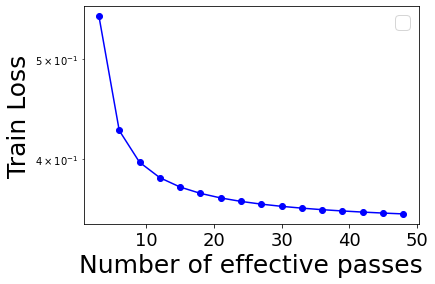

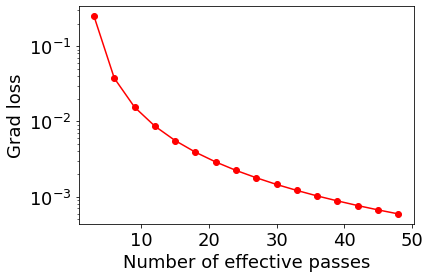

In [7]:
plot_loss(history)
plot_norm_square_grad(history)

## SMG with Diminishing Learning Rate Scheduler

In [ ]:
criterion = nn.SoftMarginLoss()

model = NonconvexLogisticNet(300, 1, 128)
model = model.to(device)
epoch_count = 50


scheduler = diminishing_learning_rate_scheduler(0.01, 8)

# beta is proposed in paper and epoch_count is inferenced from the graphs
history = SMG_train(model, criterion, epoch_count, w8a_train_loader, w8a_test_loader, 
                    scheduler, beta=0.5, verbose=True)

Epoch 1 / 50: avg. loss of last epoch 0.5470482443296221
avg. grad_norm of last epoch 0.2465252926009233
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 2 / 50: avg. loss of last epoch 0.41301976477597324
avg. grad_norm of last epoch 0.029896737798467667
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 3 / 50: avg. loss of last epoch 0.3731838704580064
avg. grad_norm of last epoch 0.004662036323248069
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 4 / 50: avg. loss of last epoch 0.365047615924316
avg. grad_norm of last epoch 0.0024387915133243267
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 5 / 50: avg. loss of last epoch 0.3614265227088253
avg. grad_norm of last epoch 0.001692090518395656
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 6 / 50: avg. loss of last epoch 0.3590114738785965
avg. grad_norm of last epoch 0.0012679540915811706
Current train acc:

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/SMG-w8a-History/SMG_diminishingLR.json", history)

No handles with labels found to put in legend.


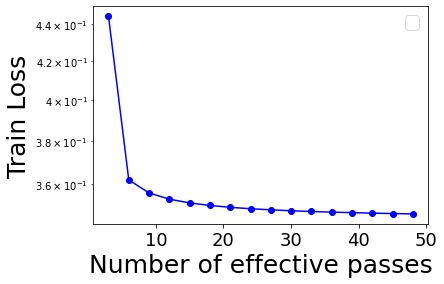

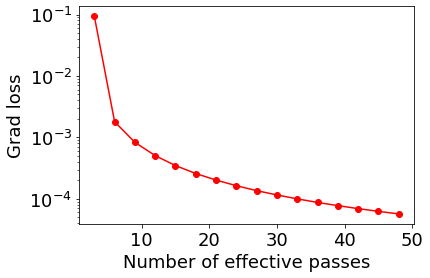

In [8]:
plot_loss(history)
plot_norm_square_grad(history)

## SMG with Exponential Learning Rate Scheduler

In [ ]:
criterion = nn.SoftMarginLoss()

model = NonconvexLogisticNet(300, 1, 128)
model = model.to(device)
epoch_count = 50

scheduler = exponential_learning_rate_scheduler(0.005, 0.99)

# beta is proposed in paper and epoch_count is inferenced from the graphs
history = SMG_train(model, criterion, epoch_count, w8a_train_loader, w8a_test_loader, 
                    scheduler, beta=0.5, verbose=True)

Epoch 1 / 50: avg. loss of last epoch 0.5749054435267585
avg. grad_norm of last epoch 0.2949131204937286
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 2 / 50: avg. loss of last epoch 0.4138227862272675
avg. grad_norm of last epoch 0.03085534706657932
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 3 / 50: avg. loss of last epoch 0.37106131244578944
avg. grad_norm of last epoch 0.003985816024398351
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 4 / 50: avg. loss of last epoch 0.3632876393635616
avg. grad_norm of last epoch 0.002030474698153323
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 5 / 50: avg. loss of last epoch 0.35992572270277584
avg. grad_norm of last epoch 0.0014063076152495164
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 6 / 50: avg. loss of last epoch 0.357677304045505
avg. grad_norm of last epoch 0.001046849621157754
Current train acc: 

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/SMG-w8a-History/SMG_ExponentialLR.json", history)

No handles with labels found to put in legend.


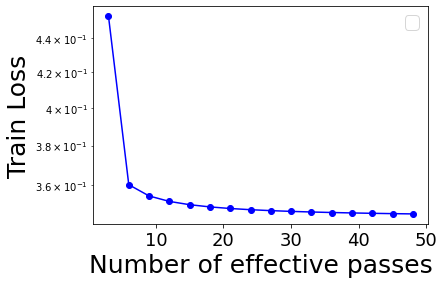

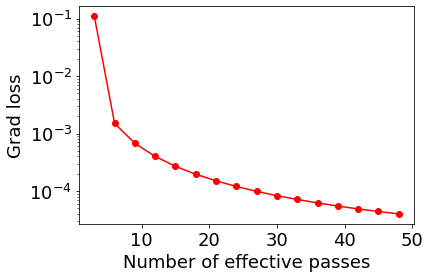

In [10]:
plot_loss(history)
plot_norm_square_grad(history)

## SMG with Cosine Learning Rate Scheduler

In [ ]:
criterion = nn.SoftMarginLoss()

model = NonconvexLogisticNet(300, 1, 128)
model = model.to(device)
epoch_count = 50


scheduler = cosine_learning_rate_scheduler(0.005, epoch_count)

# beta is proposed in paper and epoch_count is inferred from the graphs
history = SMG_train(model, criterion, epoch_count, w8a_train_loader, w8a_test_loader, 
                    scheduler, beta=0.5, verbose=True)

Epoch 1 / 50: avg. loss of last epoch 0.4962061557618281
avg. grad_norm of last epoch 0.13379296651287315
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 2 / 50: avg. loss of last epoch 0.38058679785490557
avg. grad_norm of last epoch 0.008729383016011307
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 3 / 50: avg. loss of last epoch 0.35554021436601824
avg. grad_norm of last epoch 0.0007587778383892463
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 4 / 50: avg. loss of last epoch 0.3522479550958615
avg. grad_norm of last epoch 0.0003998508710299713
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 5 / 50: avg. loss of last epoch 0.3509162488477369
avg. grad_norm of last epoch 0.00028814087357385896
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 6 / 50: avg. loss of last epoch 0.3499930535938979
avg. grad_norm of last epoch 0.00022180085134557373
Current tra

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/SMG-w8a-History/SMG_CosineLR.json", history)

No handles with labels found to put in legend.


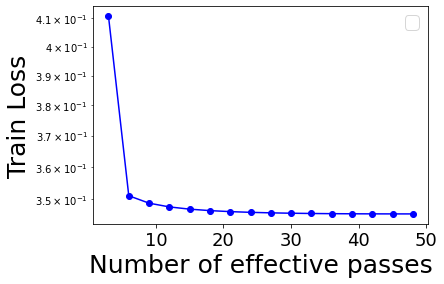

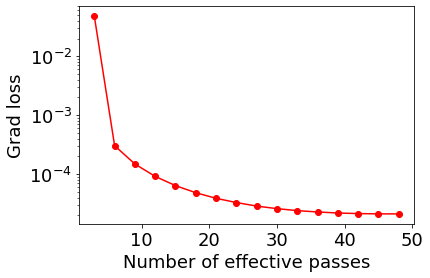

In [12]:
plot_loss(history)
plot_norm_square_grad(history)

# 2- Train Other Models and Compare over SMG

## Training with Adam


In [ ]:
import torch.optim as optim

criterion = nn.SoftMarginLoss()

model = NonconvexLogisticNet(300, 1, 128)
model = model.to(device)
epochs = 50


scheduler = constant_learning_rate_scheduler(0.0001)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))

adam_history = train(model, criterion, optimizer, epochs, w8a_train_loader, w8a_test_loader, scheduler)

Epoch 1 / 50: avg. loss of last epoch 0.6439646287032381
Epoch 1 / 50: avg. grad_norm of last epoch 0.41329613808205345
Current train acc: 86.38967617439546%, test acc: 86.3754932780416%
Epoch 2 / 50: avg. loss of last epoch 0.5392904060553415
Epoch 2 / 50: avg. grad_norm of last epoch 0.16906824391355676
Current train acc: 97.09340891274196%, test acc: 97.01023342920206%
Epoch 3 / 50: avg. loss of last epoch 0.4916950777865251
Epoch 3 / 50: avg. grad_norm of last epoch 0.09024795585313954
Current train acc: 97.09943918470724%, test acc: 97.0169219450204%
Epoch 4 / 50: avg. loss of last epoch 0.46361852027010825
Epoch 4 / 50: avg. grad_norm of last epoch 0.056794291920426086
Current train acc: 97.1034593660174%, test acc: 97.0169219450204%
Epoch 5 / 50: avg. loss of last epoch 0.44455006945557085
Epoch 5 / 50: avg. grad_norm of last epoch 0.03924938930156994
Current train acc: 97.1054694566725%, test acc: 97.0169219450204%
Epoch 6 / 50: avg. loss of last epoch 0.43045848247266827
Epoch

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/w8a-Other-Optimizers/ADAM_constantLR.json", adam_history)

No handles with labels found to put in legend.


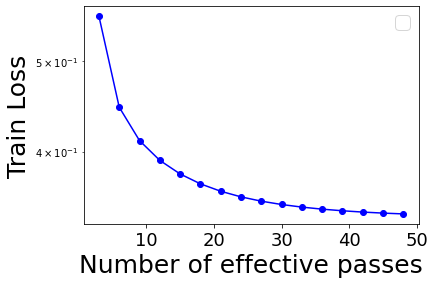

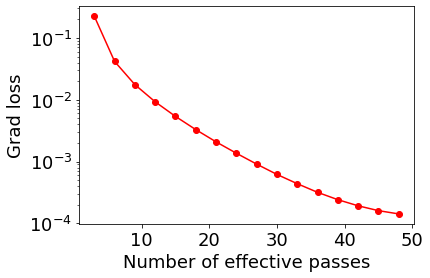

In [13]:
plot_loss(adam_history)
plot_norm_square_grad(adam_history)

## Training with SGD


In [ ]:
import torch.optim as optim
criterion = nn.SoftMarginLoss()

model = NonconvexLogisticNet(300, 1, 128)
model = model.to(device)
epochs = 50


scheduler = constant_learning_rate_scheduler(0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001)

sgd_history = train(model, criterion, optimizer, epochs, w8a_train_loader, w8a_test_loader, scheduler)

Epoch 1 / 50: avg. loss of last epoch 0.643019724101641
Epoch 1 / 50: avg. grad_norm of last epoch 0.43146427075153165
Current train acc: 96.67732014713863%, test acc: 96.70925021737676%
Epoch 2 / 50: avg. loss of last epoch 0.5326413777946178
Epoch 2 / 50: avg. grad_norm of last epoch 0.19083204773577642
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 3 / 50: avg. loss of last epoch 0.48089049332546724
Epoch 3 / 50: avg. grad_norm of last epoch 0.10049398219267502
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 4 / 50: avg. loss of last epoch 0.4515290646986128
Epoch 4 / 50: avg. grad_norm of last epoch 0.06197338527856167
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 5 / 50: avg. loss of last epoch 0.4325875822297364
Epoch 5 / 50: avg. grad_norm of last epoch 0.04211180583533166
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 6 / 50: avg. loss of last epoch 0.4193362405865457
Epo

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/w8a-Other-Optimizers/SGD_constantLR.json", sgd_history)

No handles with labels found to put in legend.


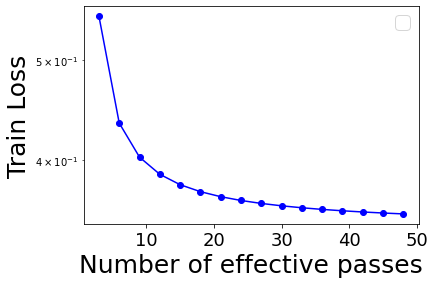

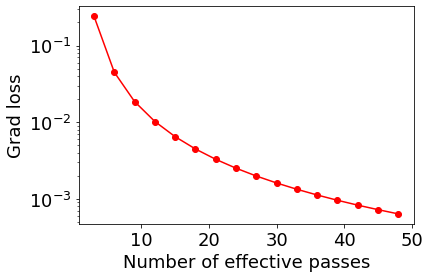

In [15]:
plot_loss(sgd_history)
plot_norm_square_grad(sgd_history)

## Training with SGD-M

In [ ]:
import torch.optim as optim
criterion = nn.SoftMarginLoss()

model = NonconvexLogisticNet(300, 1, 128)
model = model.to(device)
epoch_count = 50


scheduler = constant_learning_rate_scheduler(0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)

sgdm_history = train(model, criterion, optimizer, epochs, w8a_train_loader, w8a_test_loader, scheduler)

Epoch 1 / 50: avg. loss of last epoch 0.5864996922837082
Epoch 1 / 50: avg. grad_norm of last epoch 0.31206565277218473
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 2 / 50: avg. loss of last epoch 0.4650462274833047
Epoch 2 / 50: avg. grad_norm of last epoch 0.08008223683383409
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 3 / 50: avg. loss of last epoch 0.425380140712516
Epoch 3 / 50: avg. grad_norm of last epoch 0.03567372311500818
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 4 / 50: avg. loss of last epoch 0.4054758497128093
Epoch 4 / 50: avg. grad_norm of last epoch 0.020295420065030025
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 5 / 50: avg. loss of last epoch 0.39343568489535713
Epoch 5 / 50: avg. grad_norm of last epoch 0.013133823753886087
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 6 / 50: avg. loss of last epoch 0.3853502137562401
E

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/w8a-Other-Optimizers/SGD-M_constantLR.json", sgdm_history)

No handles with labels found to put in legend.


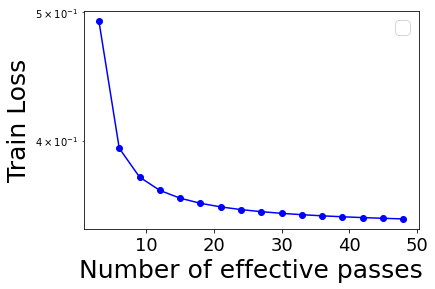

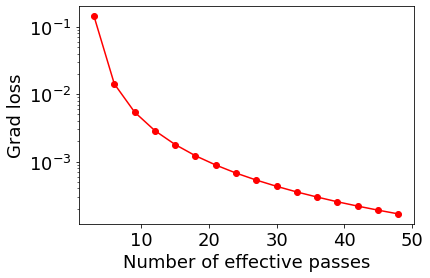

In [16]:
plot_loss(sgdm_history)
plot_norm_square_grad(sgdm_history)

## Training with SSMG


In [ ]:
import torch.optim as optim

criterion = nn.SoftMarginLoss()

model = NonconvexLogisticNet(300, 1, 128)
model = model.to(device)
epoch_count = 50


scheduler = constant_learning_rate_scheduler(0.001)

#SSMG is single shuffle variant of the SMG (with different optimizer step.) 
#Thus, reload the batch by shuffling it once and disable shuffling in every epoch
w8a_train_loader, w8a_test_loader = w8a_data_loader(w8a_X_train, w8a_Y_train, w8a_X_test, w8a_Y_test, 128, True)

# beta is proposed in paper and epoch_count is inferenced from the graphs
ssmgHistory = SSMG_train(model, criterion, epoch_count, w8a_train_loader, w8a_test_loader, 
                    scheduler, beta=0.5, verbose=True)

Epoch 1 / 50: avg. loss of last epoch 0.6138935392747689
avg. grad_norm of last epoch 0.3630633254230444
Current train acc: 97.06727773422581%, test acc: 97.02361046083874%
Epoch 2 / 50: avg. loss of last epoch 0.5203456815426
avg. grad_norm of last epoch 0.16647438669080156
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 3 / 50: avg. loss of last epoch 0.4742154539968528
avg. grad_norm of last epoch 0.09131220920547806
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 4 / 50: avg. loss of last epoch 0.447227156298367
avg. grad_norm of last epoch 0.05745581615611658
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 5 / 50: avg. loss of last epoch 0.4295310140346173
avg. grad_norm of last epoch 0.03948512893039235
Current train acc: 97.02707592112404%, test acc: 96.96341381847368%
Epoch 6 / 50: avg. loss of last epoch 0.4170289061135818
avg. grad_norm of last epoch 0.028819493268049903
Current train acc: 97.027075

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/w8a-Other-Optimizers/SSMG_constantLR.json", ssmgHistory)

No handles with labels found to put in legend.


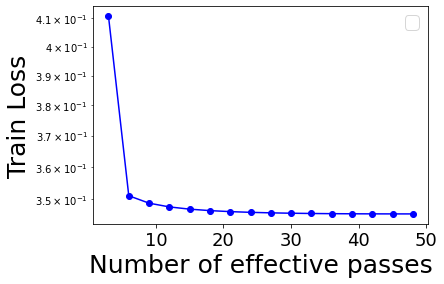

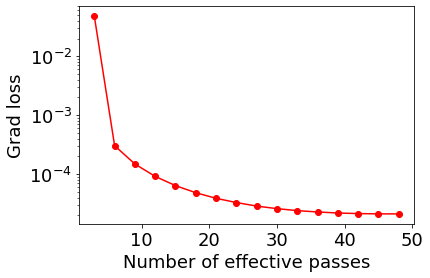

In [17]:
plot_loss(ssmgHistory)
plot_norm_square_grad(ssmgHistory)